# Predicting Metastatic Breast Cancer
#### Matthew Maggiolini

## Introduction

Medical diagnosis is an area of intense research for machine learning algorithms. Currently, many diagnoses for conditions ranging from cancer to infections need a trained technician or medical professional to analyse image data, whether from xrays, scans, cell culture images or many other sources before a diagnosis can be determined. If machine learning algortithms and pipelines can be written to take either the raw images or processed data extracted from the raw images and determine a diagnosis at a rate at least as accurate as a trained professional then much time and many resources could be saved freeing up those highly trained individuals to perform other tasks.

The dataset I have chosen to work was downloaded from the UCI Machine Learning Repository at https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic). This data is comprised of 32 attributes across 569 samples of relatively well-balanced metastatic breast cancer or benign breast cancer. The data points were generated by manually measuring certain features of cell nuclei in fixed breast-cancer biospy samples leading to mean, worst (mean of three largest values) and standard error measurements across the following features:

a) radius (mean of distances from center to points on the perimeter)

b) texture (standard deviation of gray-scale values)

c) perimeter

d) area

e) smoothness (local variation in radius lengths)

f) compactness (perimeter^2 / area - 1.0)

g) concavity (severity of concave portions of the contour)

h) concave points (number of concave portions of the contour)

i) symmetry

j) fractal dimension ("coastline approximation" - 1)

(ref https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))

All datatypes are of decimal or float type numbers, except the diagnosis which is categorical.

Some of these features will be closely related to one another. For example radius, perimeter and area are naturally correlated to one another.

The objectives of the project are to take this dataset and perform the necessary pre-processing steps in order to get the data into the desired state for machine learning algorithm training. To perform statistical analysis on and analyse the distributions of the different features of the data. To identify how we can reduce the dimensionality of this dataset to its most critical components.

Finally to select, train and test a machine learning algorithm to distinguish between the metastatic and benign samples in the dataset and to generate a success score for said model. To be clear I will only be using data from within this dataset but through cross validation we will be able to train and test on different parts of the dataset.

## Module and Data Import

Import the necessary modules

In [7]:
# import the modules needed for the whole notebook
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

Define a data import function that returns a pandas dataframe created from a given csv file with a header row as column names and the first column as the index.

In [8]:
# import a comma=separated file at the given filepath and return a dataframe with the first row of the file as the column 
# headers and the first column as the index of the dataframe.
def csvToDFWithHeaderAndIndex(filePath):
    try:
        df = pd.read_csv(filePath, delimiter=',', header=0, index_col=0)
    except FileNotFoundError:
        print('Error: data file "' + filePath + '" was not found. Please check the filepath given is correct and that the data file is present')
    return df

Import the data and create our dataframe

In [9]:
# import our datafile and build a dataframe from it. 
df = csvToDFWithHeaderAndIndex('data.csv')

## Data preprocessing

Check the shape of the dataframe to see how many rows and columns we have

In [10]:
# find the number of rows and columns in our dataframe
df.shape

(569, 32)

Check our dataframe for null values.

In [11]:
# check for null value counts in our dataframe columns
df.isnull().sum()

diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed: 32                569
dtype: i

We can see that there is one column that contains many null values. Let's check if it's entirely null values.

In [12]:
# check if the number of null values in the column matches the number of rows in the dataframe.
df['Unnamed: 32'].isnull().sum() == df.shape[0]

True

Every row in this column has a null value so we can safely remove that column. In fact let's do that for all columns that are entirely null values.

In [13]:
# define a function that would drop inplace all columns which have entirely null values in them in from the given dataframe
def dropNullColumnsInPlace(dataframe):
    for column in dataframe.columns:
        if dataframe[column].isnull().sum() == dataframe.shape[0]:
            dataframe.drop(column, axis=1, inplace=True)

In [14]:
dropNullColumnsInPlace(df)

Let's recheck our null value counts

In [15]:
# check for null value counts in our dataframe columns
df.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Null values have been removed from the data. What datatypes do we have in our columns and do we have any columns with multiple datatypes?

In [16]:
# get some summary information about our dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

We have almost entirely numerical data, except the data column which should be categorical data. It would be better to change the datatype of this column from object to categorical.

In [17]:
# change the datatype of the diagnosis column values to 'category'
df['diagnosis'] = df['diagnosis'].astype('category')

### Establishing first normal form (1NF)

In [18]:
# check the datatype of the 'diagnosis' column
df['diagnosis'].dtype

CategoricalDtype(categories=['B', 'M'], ordered=False)

We can see above from the 'dtype' property of the 'diagnosis' column in the dataframe that there are two catergories only: 'B' or 'M'. There are no comma separated values in this column for any samples. The rest of the columns we already know contain decimal values therefore all columns contain only scalar values. This is important in establishing that our dataframe is in First Normal Form. 

We should also check for any duplicates in the table.

In [19]:
# check the index column (sample numbers) has only unique values
df.index.is_unique

True

Our index values (which were the sample ids in the original data) are unique indicating that we have no repeating samples in the dataframe. Having established that our table is made up of columns containing scalar values and that no entities are repeated we can say that our dataframe is in first normal form (1NF). 

## Statistical Analysis and Visualisations

### How balanced is the dataset?

In terms of choosing our ML model and setting its hyperparameters and also for understanding our statistical analysis and visualistations more clearly we should try to understand how balanced (or imbalanced) our dataset is in term of the two categories of the target array. 

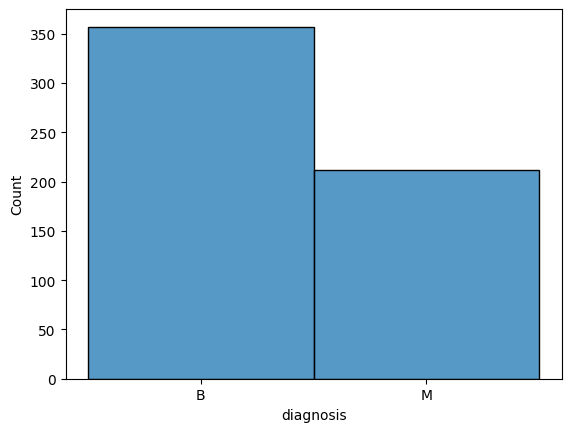

In [20]:
# plot a histogram of the two subsets of the target array.
sns.histplot(df['diagnosis'])
plt.show()

In [21]:
# divide number of benign samples by the number of metastatic samples
df.loc[df['diagnosis'] == 'B'].shape[0] / df.loc[df['diagnosis'] == 'M'].shape[0]

1.6839622641509433

The dataset includes more benign examples than malignant by a factor of approximately 1.68. This is not a significant relative imbalance in the dataset and there is also not an absolute imbalance where the number of our smaller subset (in this case metastatic samples) is very low.

### Overview of the dataset

To get an overall statistical summary of each of the features of our data we can call the discribe function on the dataframe.

In [22]:
# get a table of summary statistics for the whole dataframe (numerical columns)
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


By looking at the column names above and refering to the data dictionary that comes with this dataset we can see that 
our data contains 30 feautures that could naturally be grouped into three parts, i.e. means of the measurements taken on each image ('mean'), standard error of the meaurements taken on each image ('se') and largest of the measurements taken on each image ('worst'), which is actually the mean of the three largest measurements, it makes sense to group our data by these 3 groups including the diagnosis column for further analysis.

In [23]:
#create three new dataframes by filtering the main dataframe on the column titles.
df_mean_values = df.filter(regex='_mean|diagnosis', axis=1)
df_se_values = df.filter(regex='_se|diagnosis', axis=1)
df_worst_values = df.filter(regex='_worst|diagnosis', axis=1)

#perform a visual check that we have separated our columns correctly
print('df_mean_values, of shape ' + str(df_mean_values.shape) + ' columns are: \n' + str(df_mean_values.columns.values) + '\n')
print('df_se_values, of shape ' + str(df_se_values.shape) + ' columns are: \n' + str(df_se_values.columns.values) + '\n')
print('df_worst_values, of shape ' + str(df_worst_values.shape) + ' columns are: \n' + str(df_worst_values.columns.values) + '\n')

df_mean_values, of shape (569, 11) columns are: 
['diagnosis' 'radius_mean' 'texture_mean' 'perimeter_mean' 'area_mean'
 'smoothness_mean' 'compactness_mean' 'concavity_mean'
 'concave points_mean' 'symmetry_mean' 'fractal_dimension_mean']

df_se_values, of shape (569, 11) columns are: 
['diagnosis' 'radius_se' 'texture_se' 'perimeter_se' 'area_se'
 'smoothness_se' 'compactness_se' 'concavity_se' 'concave points_se'
 'symmetry_se' 'fractal_dimension_se']

df_worst_values, of shape (569, 11) columns are: 
['diagnosis' 'radius_worst' 'texture_worst' 'perimeter_worst' 'area_worst'
 'smoothness_worst' 'compactness_worst' 'concavity_worst'
 'concave points_worst' 'symmetry_worst' 'fractal_dimension_worst']



The describe function gets us useful tabular data but in order to more quickly perceive features of the data it would be better to visualise the distributions of each of the measurements.

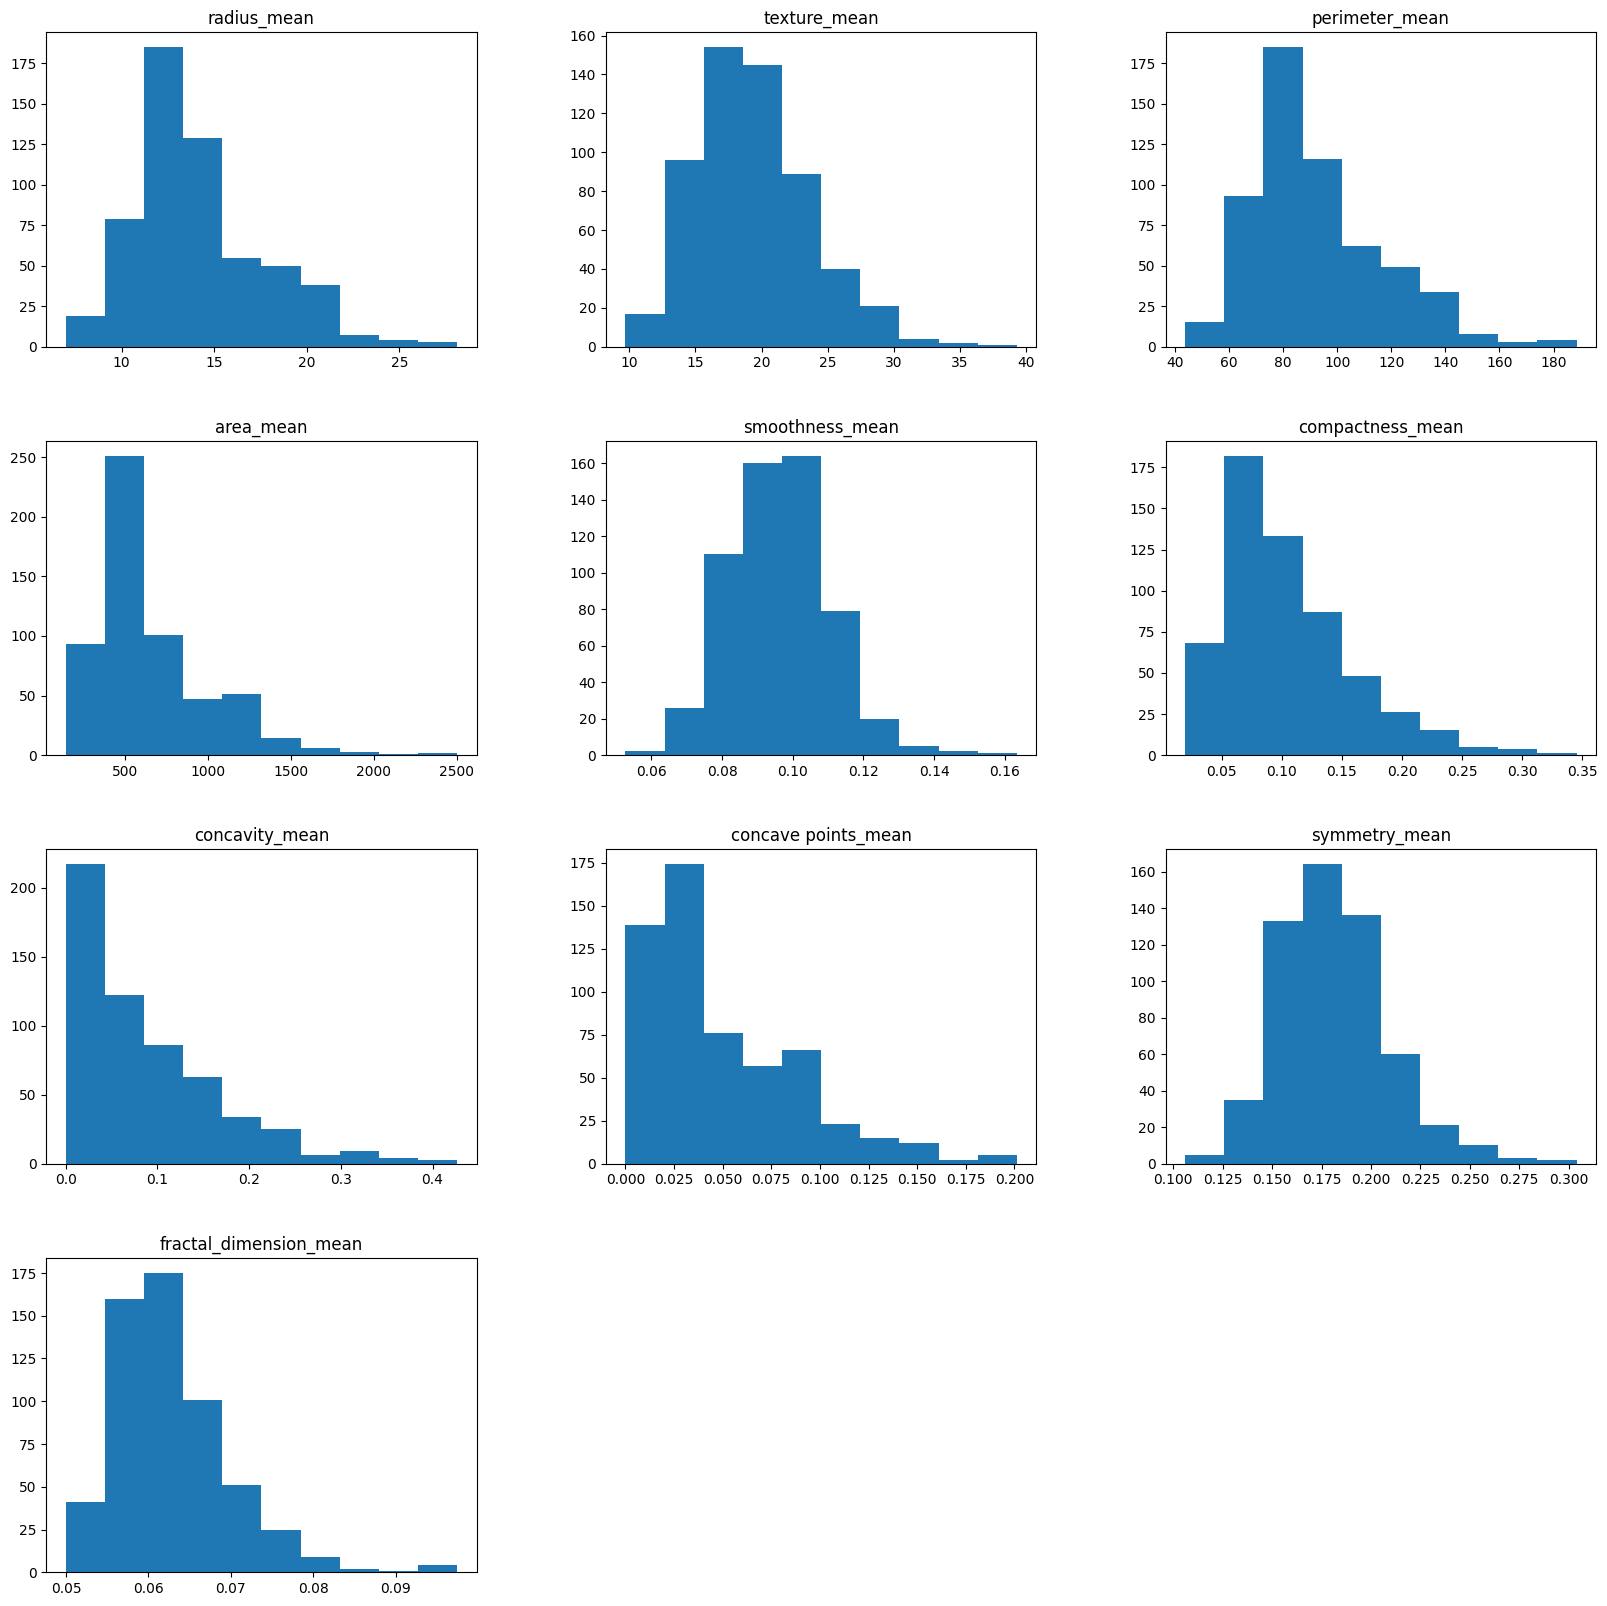

In [24]:
# plot a grid of histograms of the mean value measurements from our dataset.
df_mean_values.hist(backend='matplotlib', figsize=(20,20), grid=False)
plt.show()

As can be seen above the 10 different mean measurements taken from images of the samples in the dataset are generally distributed continuously and unimodally, some of the distributions are skewed heavily to the left (or negatively).

At the moment these distributions do not tell us much about the potential differences in the distributions of our measurements between the two 'diagnosis' categories of benign or malignant.

### Comparing benign and metastatic distributions

To see this we should separate the distributions by the diagnosis, this should give us a visual indication of whether we might be able to distinguish between the two sets with the given features and which features might be useful for accomplishing that.

I have not normalised the size of each of the sets of the target array to each other so it should be noted that heights of peaks are not directly comparable nor should any area under the curve analysis be performed at this stage.

In [25]:
# INSERT COMMENTS from here onwards
def distributionHistogramComparison(dataframe, nGridRows, nGridCols, hue=None, figsize=(20,20), title=None):
    fig, axs = plt.subplots(nGridRows, nGridCols, figsize=figsize)
    
    fig.suptitle(title, y=0.92 ,fontsize='xx-large')

    i, j = 0, 0
    for column in dataframe.columns:
        if column == hue:
            continue
        sns.histplot(ax=axs[i][j], data=dataframe, x=column, hue=hue, kde=True)
        metastatic = dataframe.loc[dataframe['diagnosis'] == 'M', column]
        benign = dataframe.loc[dataframe['diagnosis'] == 'B', column]
        ksResult = sp.stats.kstest(metastatic, benign, alternative='two-sided')
        if ksResult[1] < 0.001:
            chartKsText = "KS test \n" + "score: " + str(np.round(ksResult[0],2)) + "\n" + "p-value: <0.001"
        else:
            chartKsText = "KS test \n" + "score: " + str(np.round(ksResult[0],2)) + "\n" + "p-value: " + str(np.round(ksResult[1],4))
        axs[i][j].text(0.65, 0.65, chartKsText, transform=axs[i][j].transAxes, fontsize=14, verticalalignment="top")
        
        if j < nGridCols-1:
            j += 1
        else:
            i += 1
            j = 0
    if i < nGridRows:
        while j < nGridCols:
            axs[i][j].remove()
            j += 1
    plt.show()

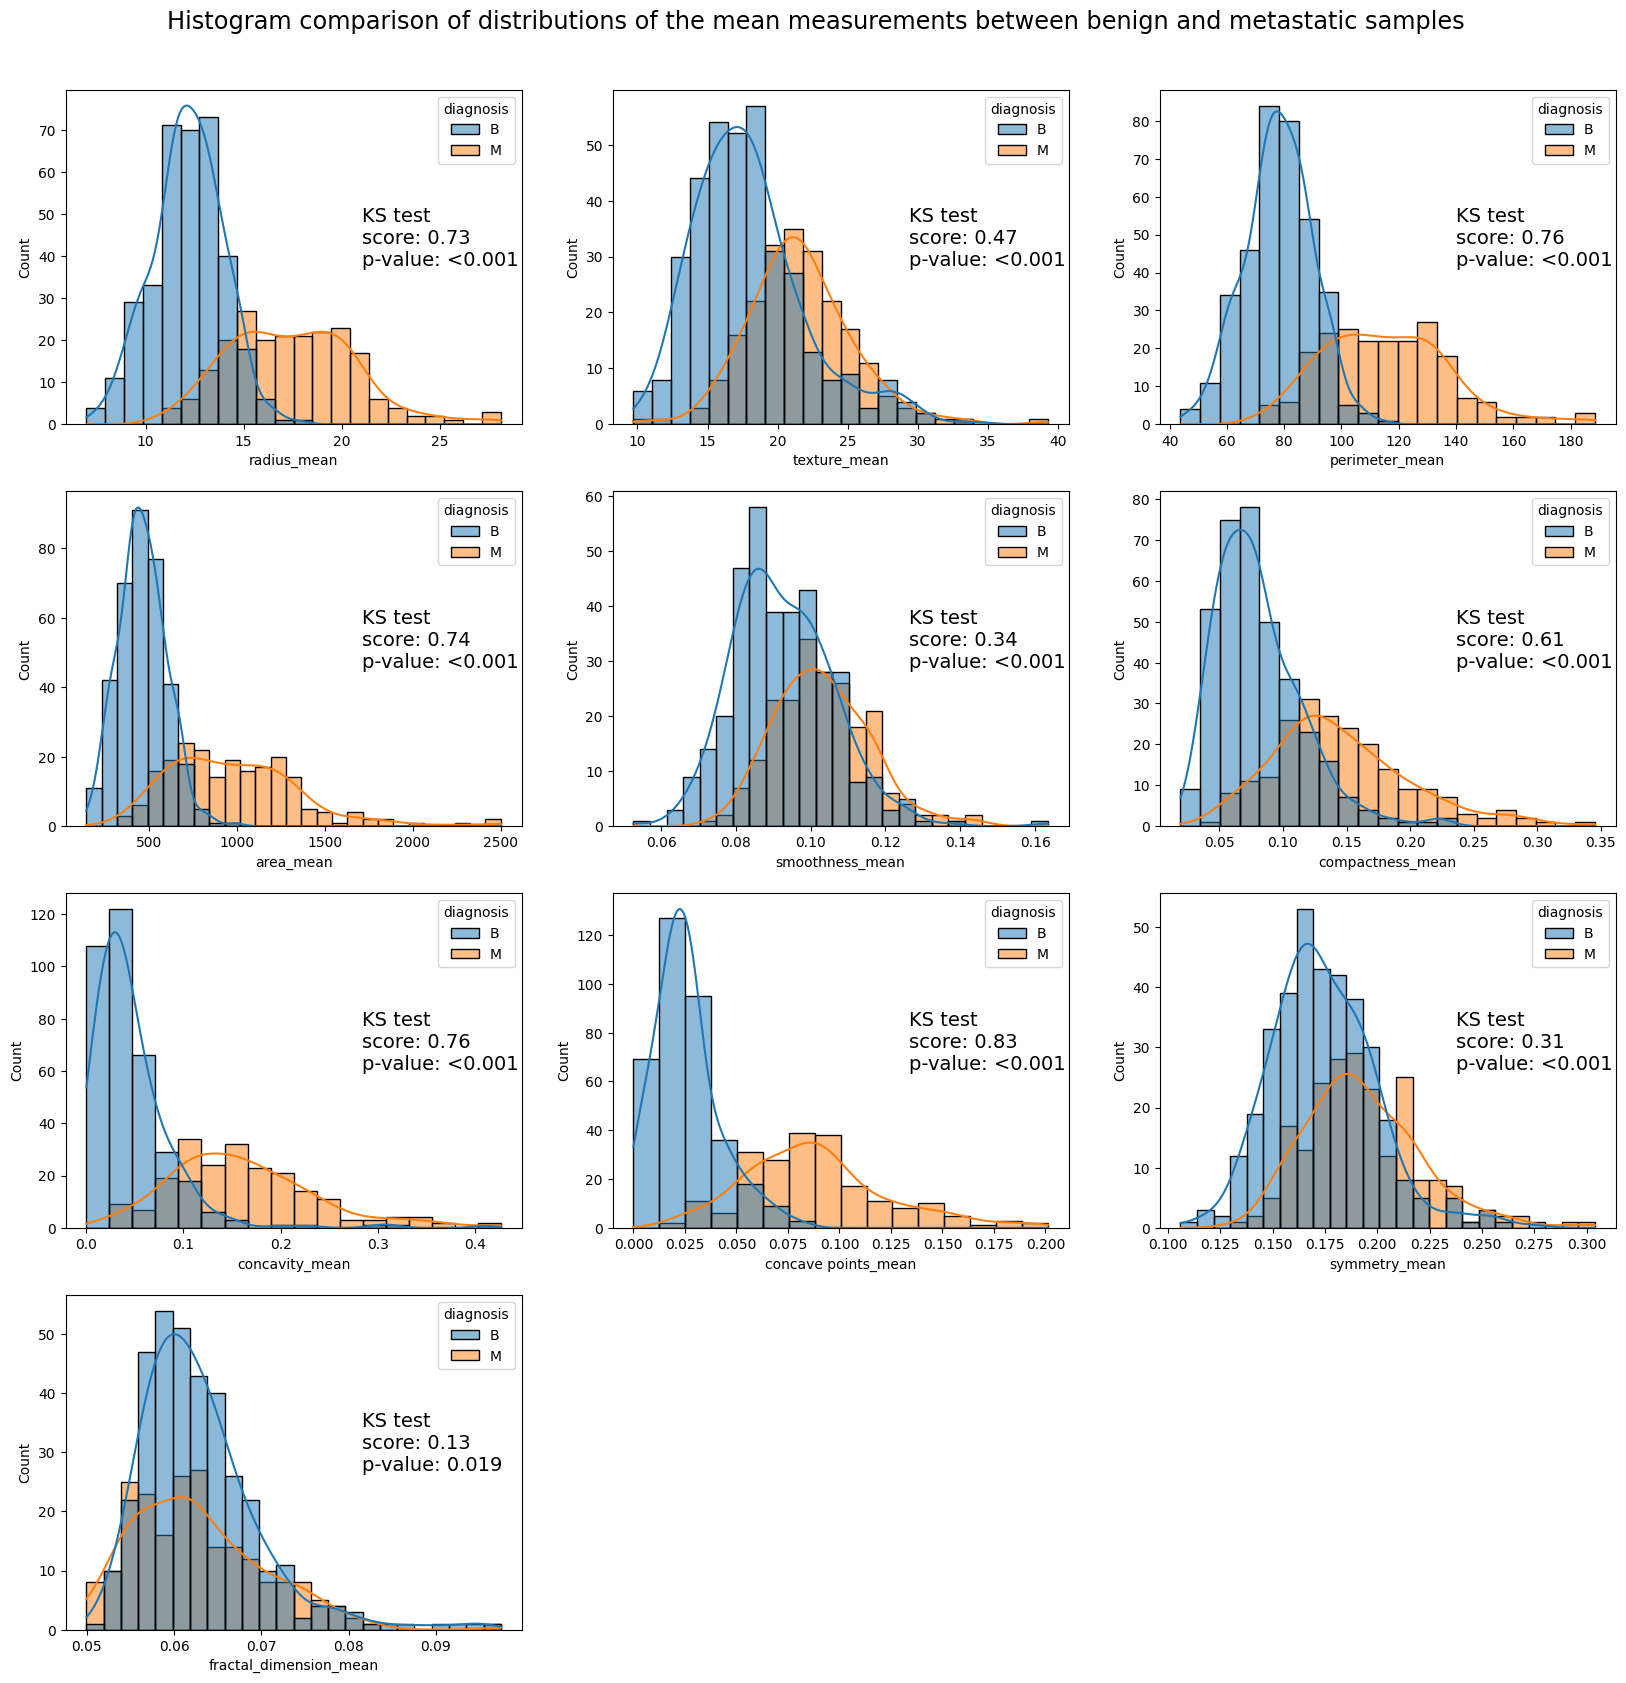

In [26]:
distributionHistogramComparison(dataframe=df_mean_values, hue='diagnosis', nGridRows=4, nGridCols=3, 
                       title='Histogram comparison of distributions of the mean measurements between benign and metastatic samples')

The distributions of both the begnin and metastatic samples across the ten mean measurements in our dataset can be seen in the histograms above. KDEs were also plotted to give a better indicaiton of shape than the bins alone.

For each column (plot) a two-sided Kolmogorov-Smirnov (KS) test was performed and the respective graphs are annotated with both the D-score and p-value. The KS test can be used to compare two continuous distributions for similarity, the D-score can be thought of as distance between the distributions with 1 as completely different and 0 as identical. The p-value gives us the likelyhood that these two distributions could have been sampled from distributions at the distance of the D-score by chance.  

As can be seen from the plots there are a number of features in our dataset that it seems could allow us to differentiate between the two sets in the target array. Namely the features based on size of the nucleii such as radius, perimeter and area, but also concavity observed too. The comparison of the distributions seen in the symmetry and fractal dimension measurements appear to be less helpful to us in that regard.

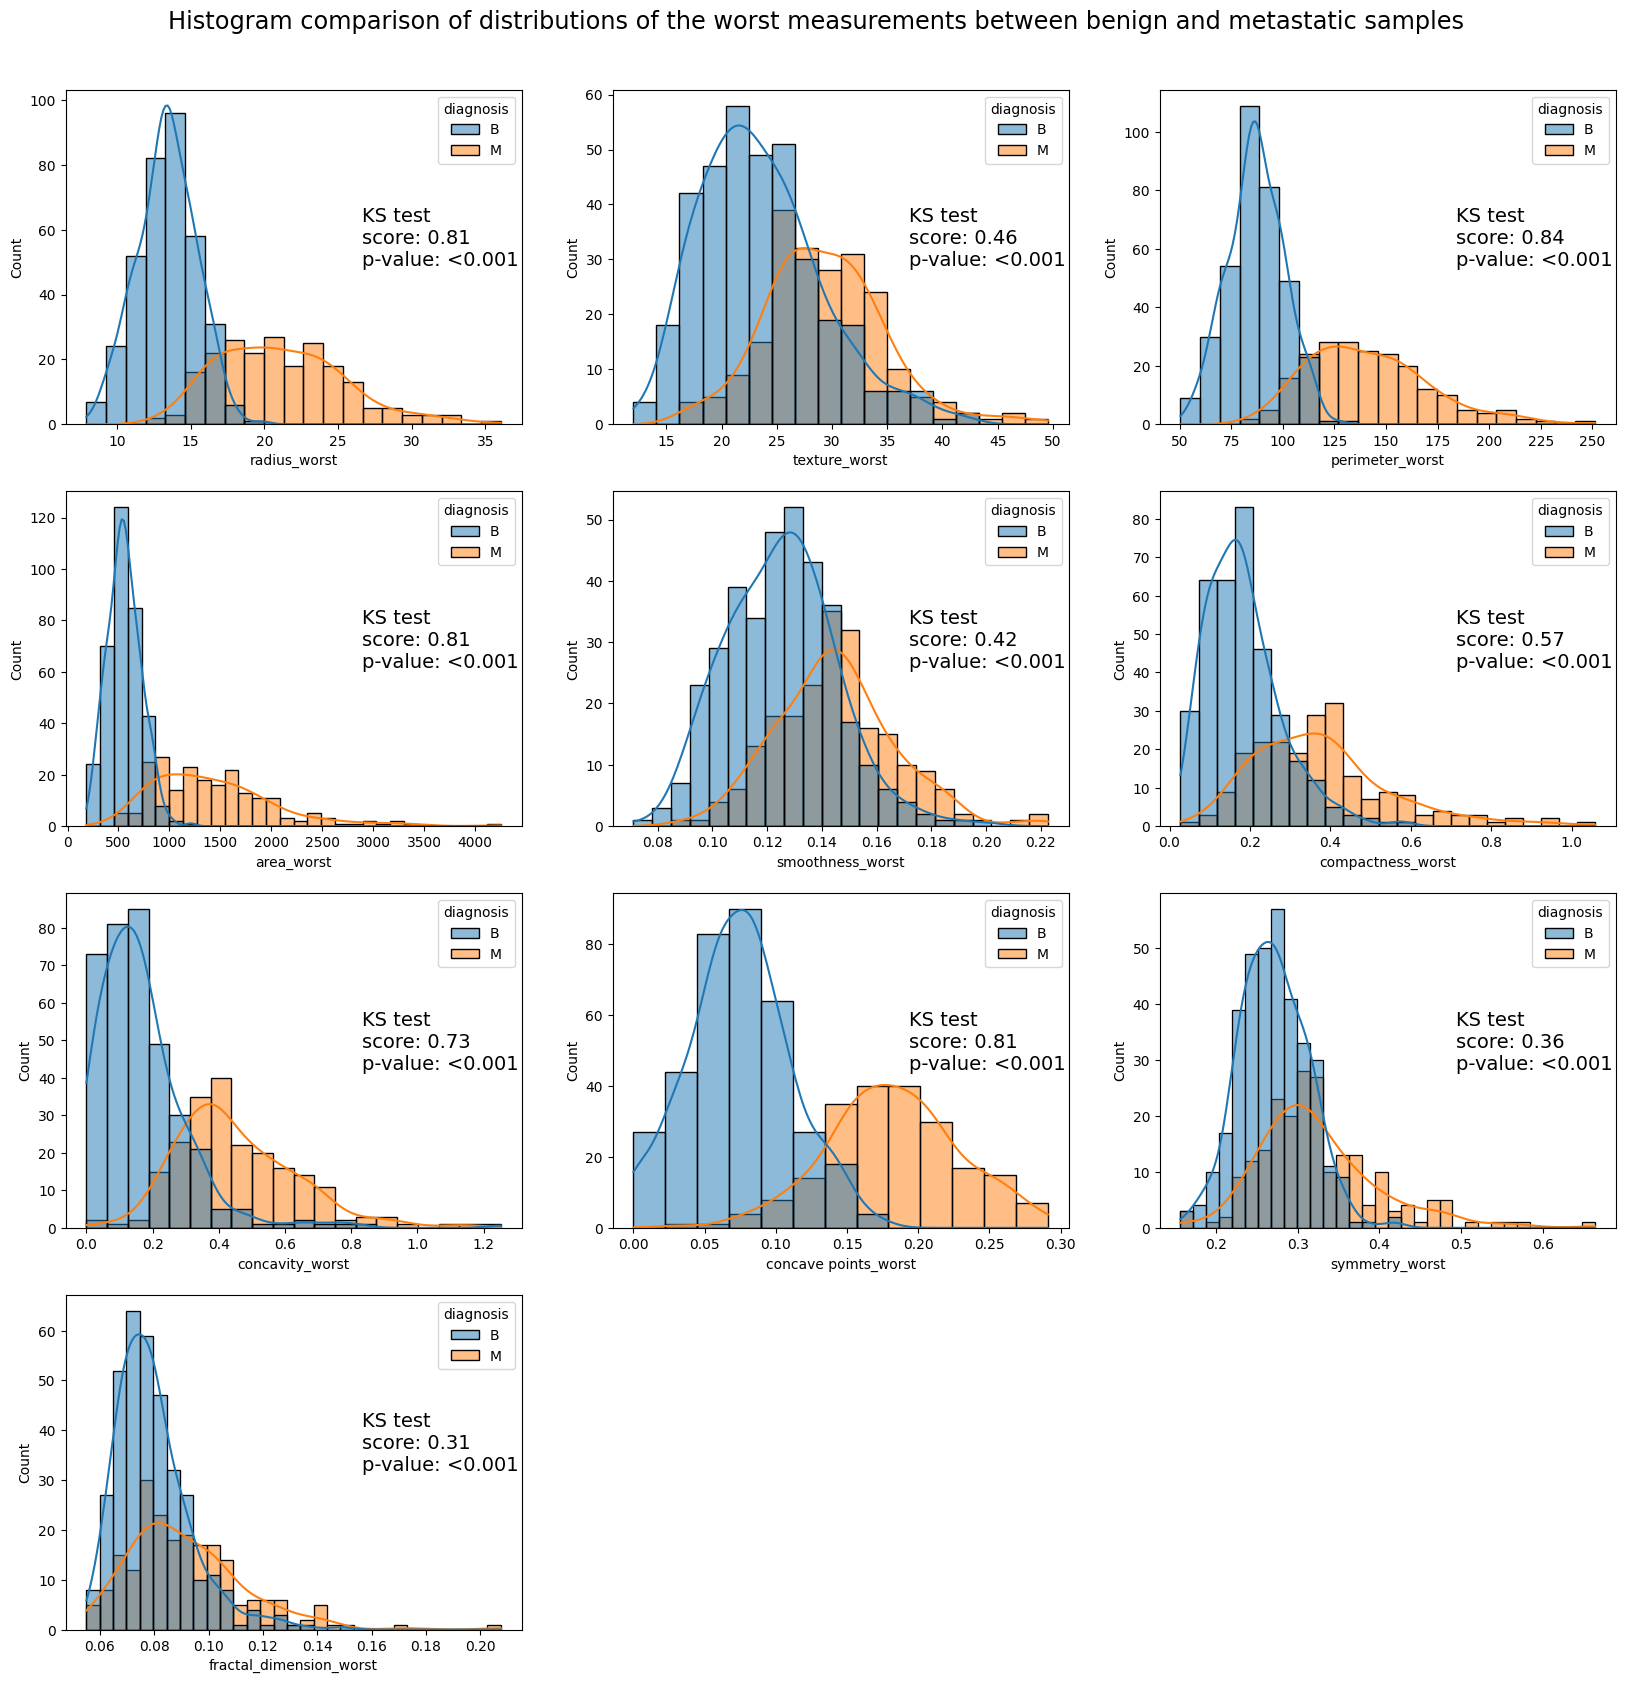

In [27]:
distributionHistogramComparison(dataframe=df_worst_values, hue='diagnosis', nGridRows=4, nGridCols=3, 
                       title='Histogram comparison of distributions of the worst measurements between benign and metastatic samples')

Above we are comparing the distributions of the worst (i.e. mean of the 3 largest measurements taken) for the 10 features between benign and metastatic samples.

Again, we can see from the visualisations and the KS scores that we have some features in our dataset (particularly concavity and size-based measurements) where we should be able to differentiate between metastatic and benign samples. 

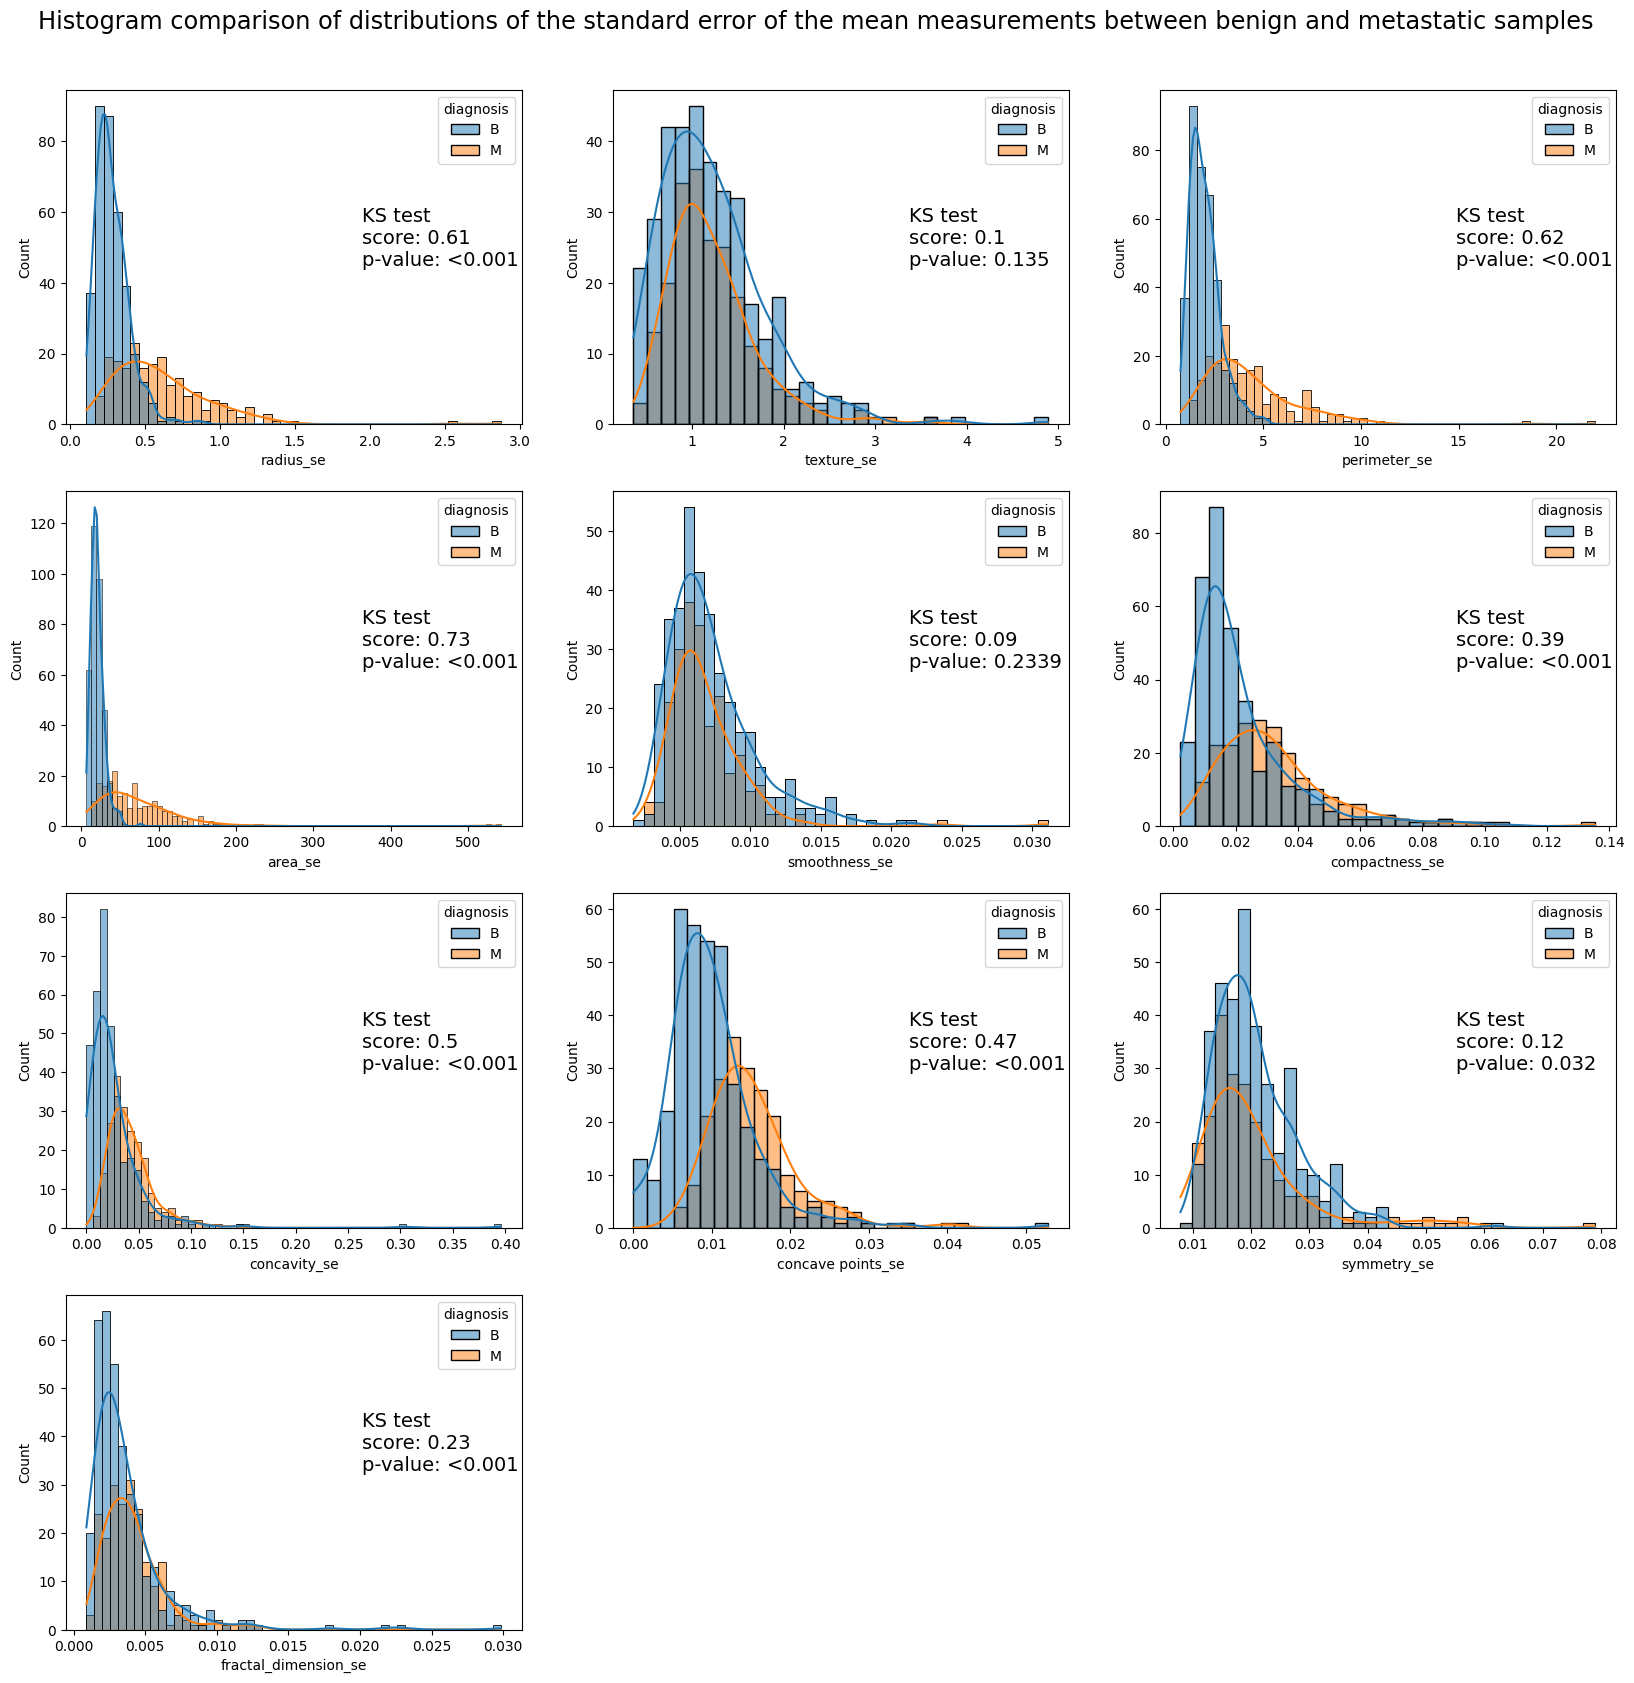

In [28]:
distributionHistogramComparison(dataframe=df_se_values, hue='diagnosis', nGridRows=4, nGridCols=3, 
                       title='Histogram comparison of distributions of the standard error of the mean measurements between benign and metastatic samples')

The final third of our dataset is comprised of the standard error values for the means of the measurements taken for each sample. As expected these features will be less powerful for classifying between the two sets of the target array and should likely not be included in the ML model. 

### Further distribution visualisations 

The histograms above give us a good indication of the differences seen between the distributions, however it is not possible to compare measures of central tendancy such as the median and interquartile range through these histograms.

In order to be able to visually compare these features boxplots would be more suitable.

In [29]:
def boxplotGrid(dataframe, nGridRows, nGridCols, figsize=(20,20), title=None):
    fig, axs = plt.subplots(nGridRows, nGridCols, figsize=figsize, squeeze=False)
    
    fig.suptitle(title, y=0.92 ,fontsize='xx-large')

    i, j = 0, 0
    for column in dataframe.columns:
        if column == 'diagnosis':
            continue
        sns.boxplot(ax=axs[i][j], x='diagnosis', y=column, data=dataframe)
        
        if j < nGridCols-1:
            j += 1
        else:
            i += 1
            j = 0
    if i < nGridRows:
        while j < nGridCols:
            axs[i][j].remove()
            j += 1
    plt.show()

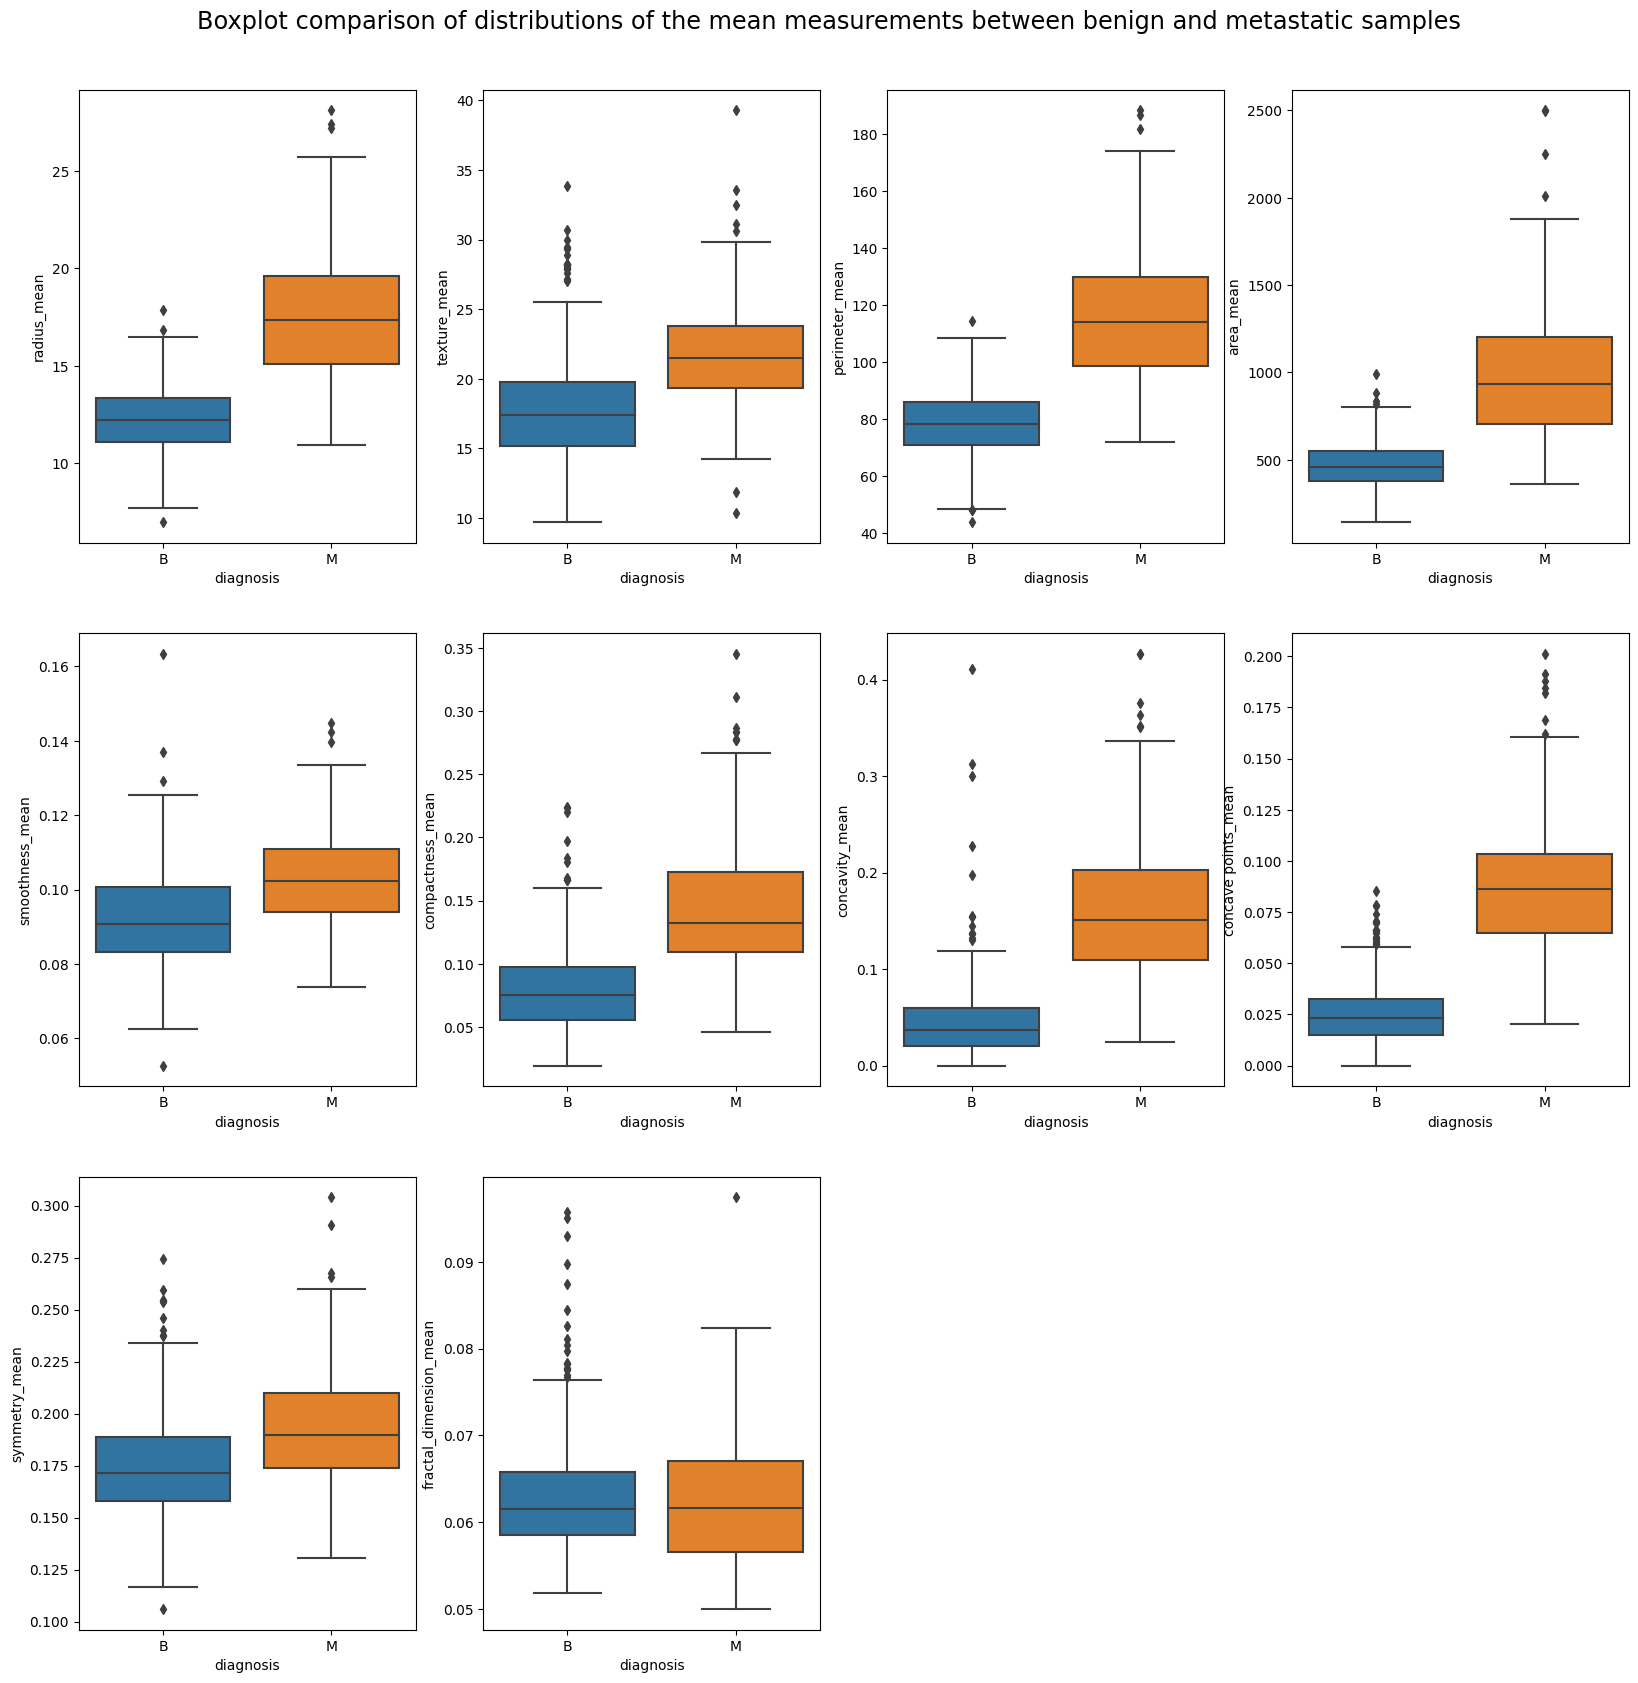

In [30]:
boxplotGrid(df_mean_values, 3, 4,
            title='Boxplot comparison of distributions of the mean measurements between benign and metastatic samples')

The boxplots allow us to compare more features of the distributions directly than the histograms do. For example we can see that the median value of radius_mean for metastatic samples is almost larger than even the largest radius_mean found among benign samples. This is also true for the 'concave points_mean' feature. This reinforces our supposition that these features could be a very useful to include in our model in order to differentiate between metastatic and benign samples.

These two particular boxplots are redrawn below to emphasise the point.

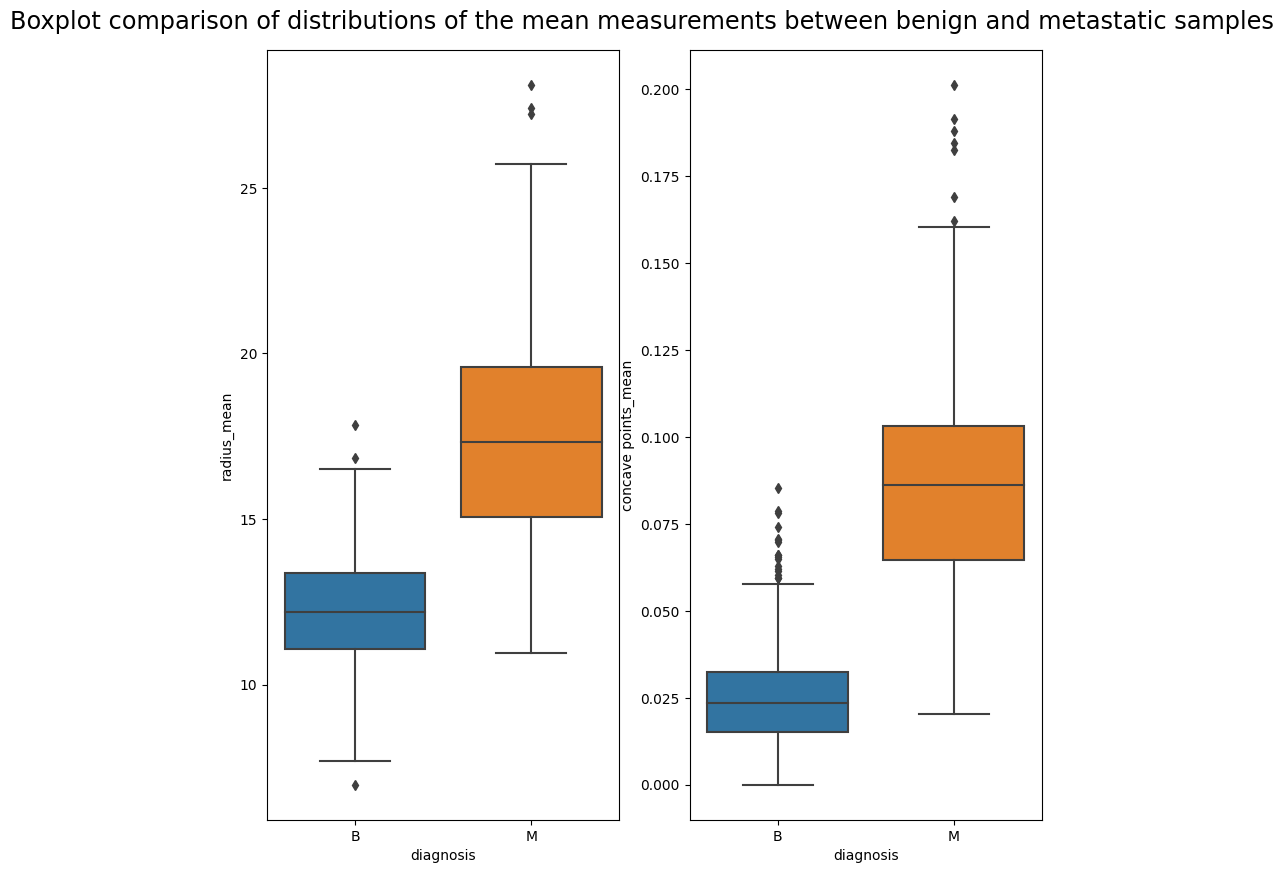

In [31]:
boxplotGrid(df_mean_values.loc[:,['diagnosis','radius_mean','concave points_mean']], 1, 2, figsize=(10,10),
            title='Boxplot comparison of distributions of the mean measurements between benign and metastatic samples')

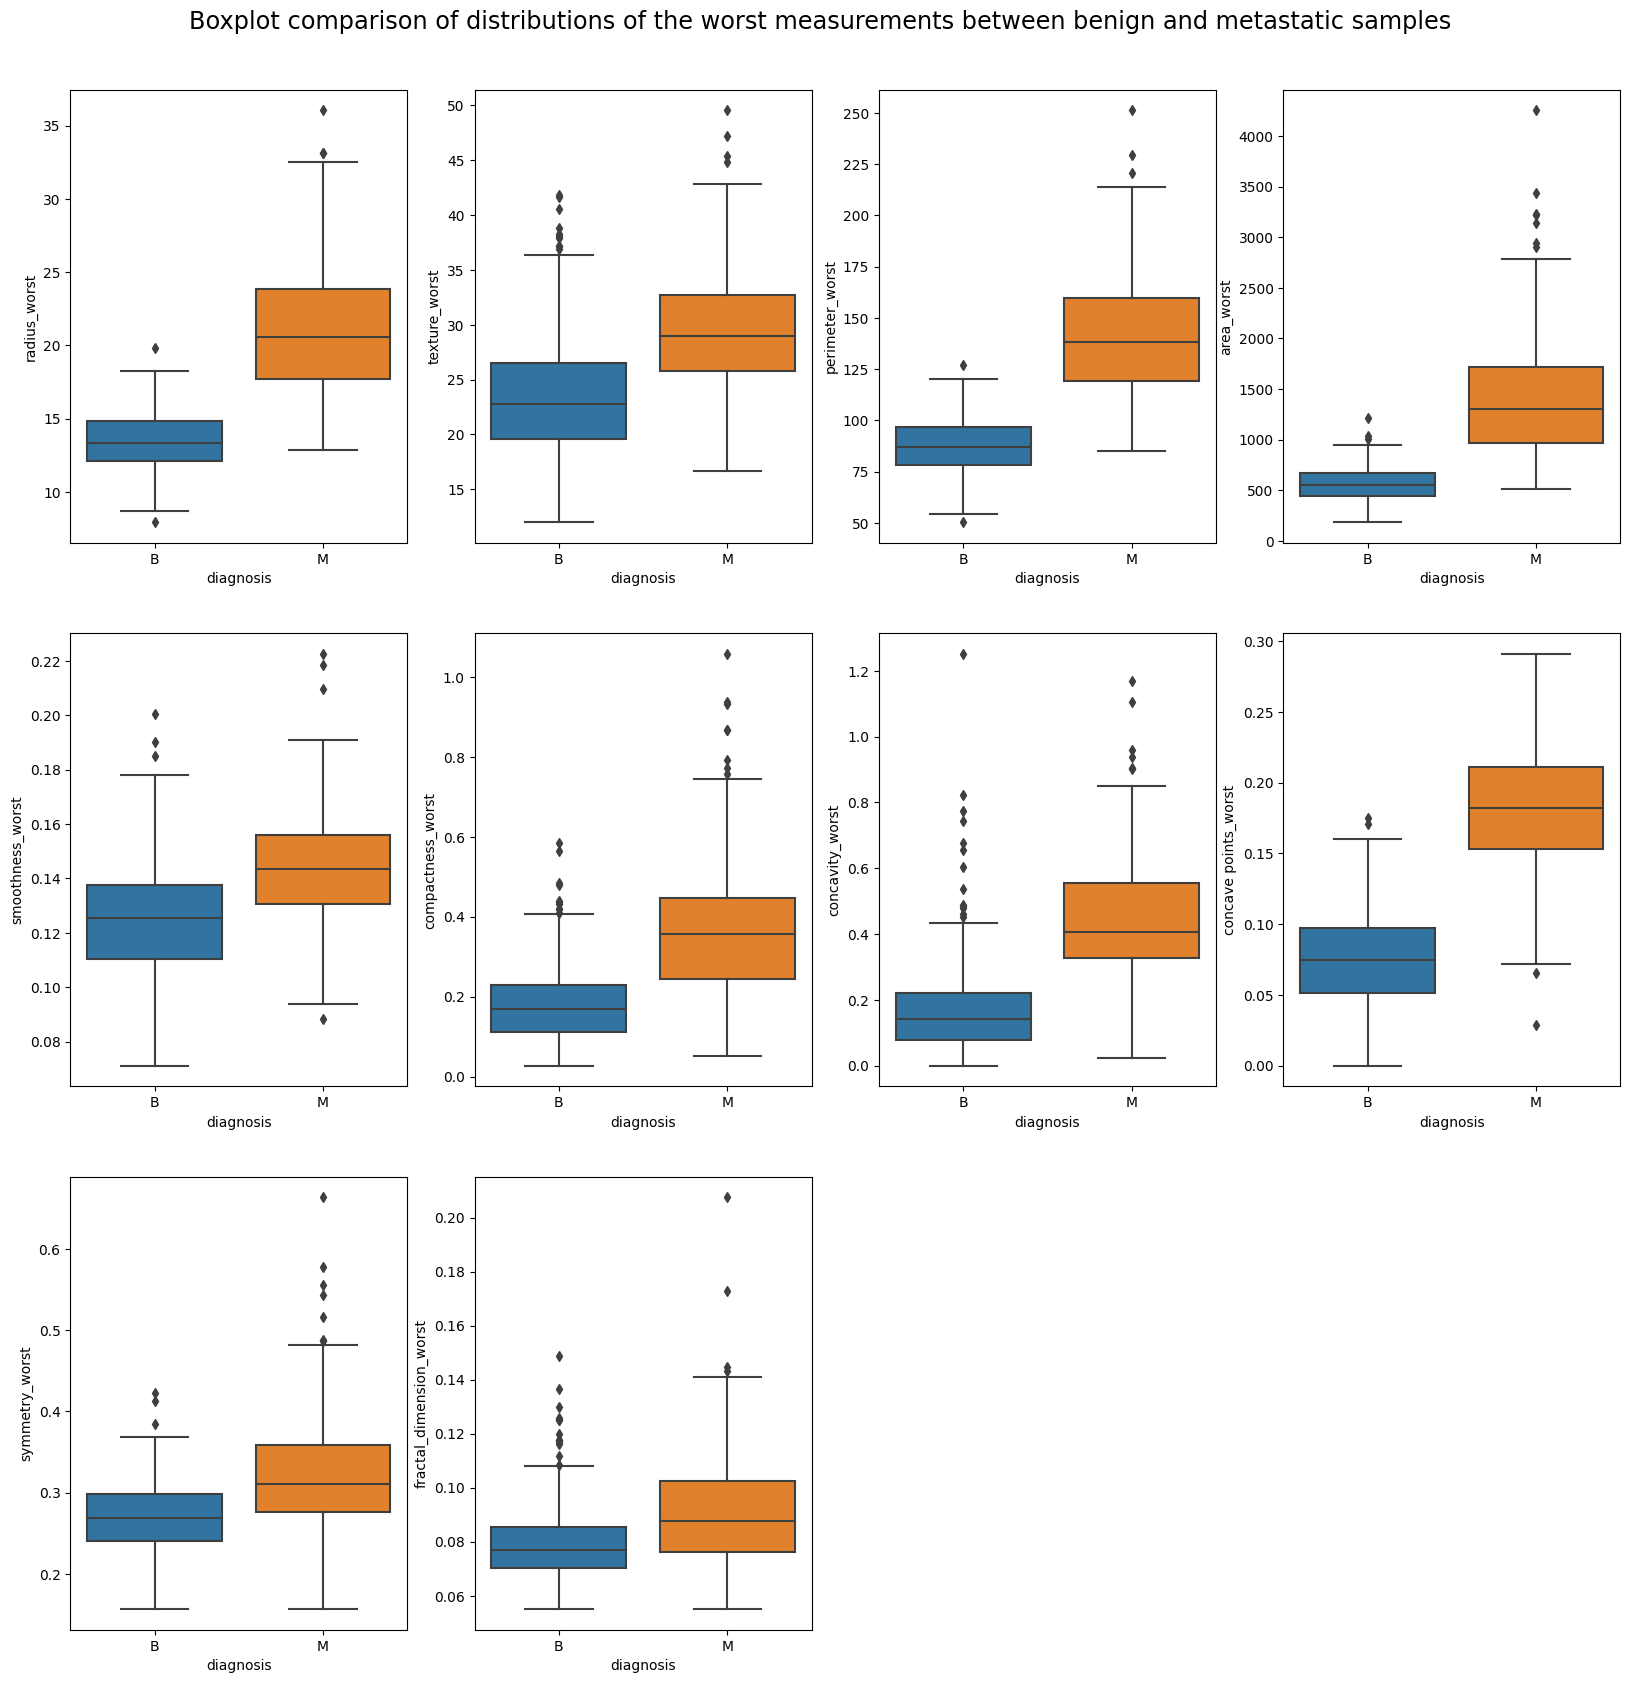

In [32]:
boxplotGrid(df_worst_values, 3, 4, 
            title='Boxplot comparison of distributions of the worst measurements between benign and metastatic samples')

Again we see that the worst measurements look as though in some cases they could be instructive to our model. However the worst measurements likely correlate closely with the mean measurements so it remains to be seen if both the mean and worst measurements together will lead to a more accurate model than only one, or a mixture, of these sets.

From the histograms, boxplots and KS analysis above we can conclude that it is worth pursuing a Machine Learning approach towards our objectives and that we should be able to perform some dimensionality reduction on our dataset while retaining its key features.

### Finding correlation within the dataset

As discussed above in the analysis of our distributions there are likely multiple features in our dataset that correlate very strongly with each other. In this section we will try to visualise the correlations present and perform a principle component analysis to reduce the dimensionality of our dataset while retaining its key features.

As determined in the analysis of our distributions the standard error features are not going to provide much power in terms of trying to categorise our samples so these features will be discarded from here onwards.

In [33]:
# filter our original dataframe for only mean and worst values
df_mean_worst_values = df.filter(regex='_mean|_worst')
#generate a table of the correlations between each feature (all samples)
df_mean_worst_values_corr = df_mean_worst_values.corr()
#generate a table of the correlations between each feature (benign samples)
df_mean_worst_values_benign_corr = df_mean_worst_values.loc[df['diagnosis'] == 'B'].corr()
#generate a table of the correlations between each feature (metastatic samples)
df_mean_worst_values_metastatic_corr = df_mean_worst_values.loc[df['diagnosis'] == 'M'].corr()

While it is common to visualise correlations in a pairplot I believe in this case a heatmap is a better alternative as the number of features is too large to visualise clearly in a pairplot grid.

In [34]:
# find the overall minimum correlation value between the three sets 
# so that all heatmaps y-axis can be scaled equally for better  comparison
vmin = min(df_mean_worst_values_corr.min().min(), 
           df_mean_worst_values_benign_corr.min().min(),
           df_mean_worst_values_metastatic_corr.min().min())

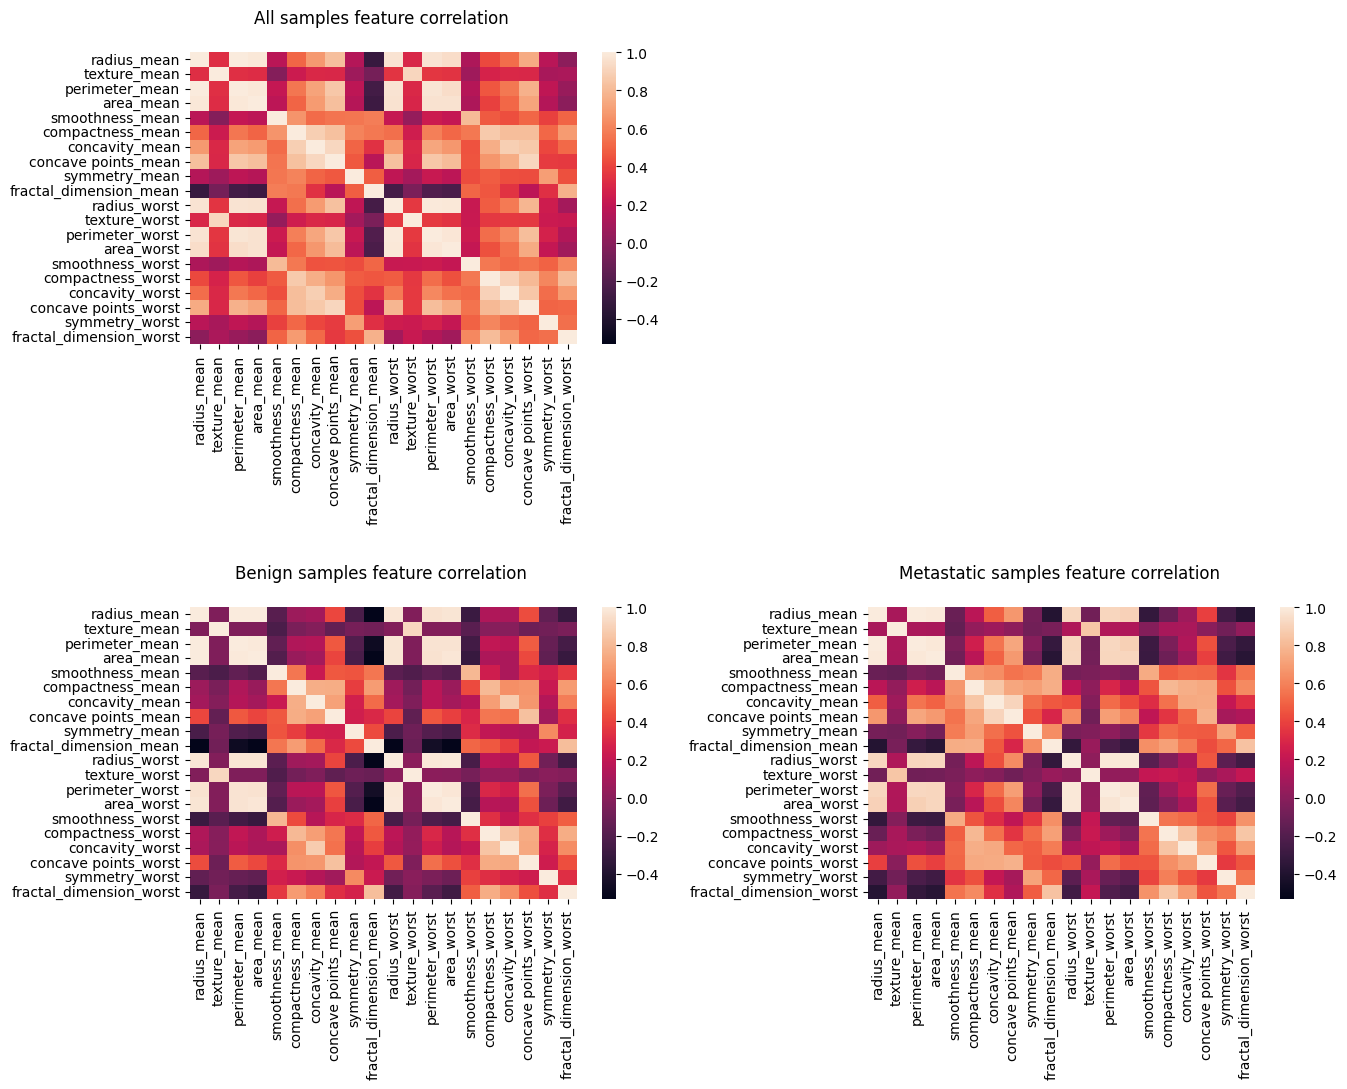

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(15,11))
sns.heatmap(ax=axs[0][0], data=df_mean_worst_values_corr, vmin=vmin, vmax=1)
sns.heatmap(ax=axs[1][0], data=df_mean_worst_values_benign_corr, vmin=vmin, vmax=1)
sns.heatmap(ax=axs[1][1], data=df_mean_worst_values_metastatic_corr, vmin=vmin, vmax=1)
axs[0][0].title.set_text('All samples feature correlation \n')
axs[1][0].title.set_text('Benign samples feature correlation \n')
axs[1][1].title.set_text('Metastatic samples feature correlation \n')
axs[0][1].remove()

plt.subplots_adjust(wspace=0.4, hspace=0.9)
plt.show()

As can be seen in the heatmap plots above there are features in our dataset that are highly correlated. Those features related to size of the nucleus, such as radius, perimeter and area are naturally highly correlated. It can also be observed by looking at the main diagnoal of either the top right or bottom left quadrant that the mean and worst values of each feature also show relatively high correlation.

Our overall dataset contains features that are highly correlated with each other. We see this to an even greater extent when we split the dataset into the two target variables. Hence it should be possible to remove some or many of the features of the dataset without losing key features.

### Principle Component Analysis

From the heatmaps it's possible to see strong correlations within our dataset between certain features. From our analysis of the histogram and boxplots we know that some of these features, such as area_mean and 'concave points_mean', are likely to provide much more descriptive power to our model. In order to reduce the dimensionality of our dataset and find the features with the most descriptive power we will no conduct a principle component analysis.

In [36]:
# make a deep copy of our original dataset without the standard error feature values or the target array 'diagnosis'
df_PCA = df.filter(regex='_mean|_worst').copy()

In [37]:
# select our model, a principle components analysis with 20 components
model = PCA(n_components = 20)

In [90]:
# fit the model to our data
model.fit(df_PCA)

PCA(n_components=20)

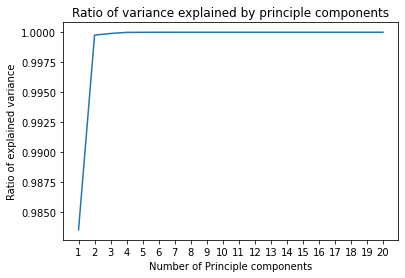

In [91]:
x = np.linspace(1,20,20)
plt.plot(x, model.explained_variance_ratio_.cumsum())
plt.title('Ratio of variance explained by principle components')
plt.xlabel('Number of Principle components')
plt.ylabel('Ratio of explained variance')
plt.xticks(range(1,21))
plt.show()

We can see from the plot above that one principle component is enough to explain nearly 100% of the variance in the data, two principle components give us only a slight increase in explaining the variance in the data. We can see the actual values below for the first three principle components.

In [92]:
model.explained_variance_ratio_[0:3].cumsum()

array([0.98350833, 0.99975856, 0.99989702])

In [93]:
# make a deep copy of our original dataset without the standard error feature values or the target array 'diagnosis'
df_PCA = df.filter(regex='_mean|_worst').copy()

#### Reducing to two dimensions

In [94]:
# select our model, a principle components analysis with 2 components
model = PCA(n_components = 2)

In [95]:
# fit the model to our data
model.fit(df_PCA)

PCA(n_components=2)

In [96]:
# transform the data to two dimensions
X_2D = model.transform(df_PCA)
X_2D.shape

(569, 2)

In [97]:
# append the data to our original dataframe in order to access the target array
df['PCA1'] = X_2D[:,0]
df['PCA2'] = X_2D[:,1]

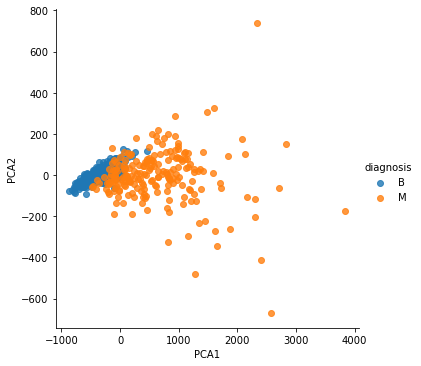

In [98]:
# plot the results of the two-dimensional principle components with diagnosis separated by hue
sns.lmplot(x='PCA1', y='PCA2', hue='diagnosis', data=df, fit_reg=False)
plt.show()

The plot of 2 component principle analysis above shows that it might be possible to get reasonable performance in separating our 2 sets within the target array as the benign set forms a relatively tight cluster in these two dimensions while the metastatic set forms a more difusse, slightly overlapping cluster in the plot. As we can see the differentiation between the two clusters is mainly along the PCA1 axis. 

#### Three dimensions

Could we get better separation of the sets by including a third principle component in the analysis?

In [99]:
# drop the PCA columns we added in our previous analysis
if 'PCA1' in df.columns:
    df.drop(['PCA1'], axis=1, inplace=True)
if 'PCA2' in df.columns:
    df.drop(['PCA2'], axis=1, inplace=True)

In [100]:
# select our model, a principle components analysis with 3 components
model = PCA(n_components = 3)

In [101]:
# fit the model to our data
model.fit(df_PCA)

PCA(n_components=3)

In [102]:
# transform the data to two dimensions
X_3D = model.transform(df_PCA)
X_3D.shape

(569, 3)

In [103]:
# append the data to our original dataframe in order to access the target array
df['PCA1'] = X_3D[:,0]
df['PCA2'] = X_3D[:,1]
df['PCA3'] = X_3D[:,2]

In [104]:
# create a colour map to pass the seaborn colours used so far for benign and metastatic samples to matpotlib
my_cmap = ListedColormap(sns.color_palette().as_hex()[0:2])

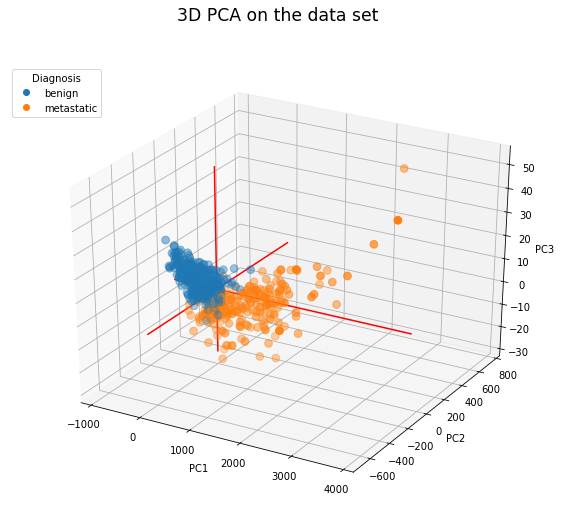

In [105]:
# adapted from https://www.python-graph-gallery.com/372-3d-pca-result - credit Yan Holtz (https://www.yan-holtz.com/)

#color codes
my_color=df['diagnosis'].cat.codes

# Plot initialisation
fig = plt.figure(figsize=(10,8))
fig.suptitle('3D PCA on the data set', fontsize='xx-large')
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['PCA1'], df['PCA2'], df['PCA3'], c=my_color, cmap=my_cmap, s=60)
 
# make simple, bare axis lines through space:
xAxisLine = ((min(df['PCA1']), max(df['PCA1'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(df['PCA2']), max(df['PCA2'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(df['PCA3']), max(df['PCA3'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# create the legend
legend1 = ax.legend(handles=scatter.legend_elements()[0],
                    labels=['benign', 'metastatic'], 
                    loc="upper left", 
                    title="Diagnosis")

plt.show()

It becomes difficult to visualise the data in 4 dimensions with 3 principle components and the colour distinguishing our diagnosis but we can see here that there is not much variance along the z-axis (or principle component 3) which suggests the PC3 is not providing much extra descriptive power.

The above confirms our suspicions that it is not necessary to include the third principle component as it is not giving us further descriptive power. The above may also be telling us that we may not see much difference in accuracy when providing our model with PC1 and PC2 over PC1 by itself. This will be investigated in the following section.

### Building a model

In [106]:
# configure our data 
X = X_2D
y = df['diagnosis']

In [107]:
# split our data into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, train_size=0.5) 

In [108]:
# choose our model and fit the data
model = GaussianNB()
model.fit(Xtrain, ytrain)

GaussianNB()

In [109]:
# calculate the accuracy score on the test data
ytest_model = model.predict(Xtest)
accuracy_score(ytest, ytest_model)

0.9017543859649123

Rather than training our model on one half of the data and testing on the other half (as above) it would be better to split our data into multiple sets of train and test data so that the whole dataset is treated in portions as training data, and testing is performed on the remaining portion. In this way we maintain the size of the dataset for training and are able to train and test on unseen data points in each test.

In [110]:
# perform cross validation and take the average of the scores from our five-fold tests
np.average(cross_val_score(model, X, y, cv=5))

0.8980593075609378

Another approach is to train our data on the entire dataset (except one sample) and then try to accurately predict the category of the remaining sample, as in the LeaveOneOut approach below.

In [111]:
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores.mean()

0.8998242530755711

As can be seen from the three accuracy scores calculated through three different methods our model can predict the correct category between Malignant and Benign in approximately 90% of cases on this dataset.

In [118]:
def modelBuilder(features, targetArray):
    X = features
    y = targetArray
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, train_size=0.5)
    model = GaussianNB()
    model.fit(Xtrain, ytrain)
    ytest_model = model.predict(Xtest)
    holdoutTestScore = accuracy_score(ytest, ytest_model)
    crossValidationScore = np.average(cross_val_score(model, X, y, cv=5))
    leaveOneOutScore = cross_val_score(model, X, y, cv=LeaveOneOut()).mean()
    
    print("holdout set model accuracy score: " + str(holdoutTestScore))
    print("Cross-validation model accuracy score: " + str(crossValidationScore))
    print("leave one out score: " + str(leaveOneOutScore))

Summary of model performance on 2 dimensional principle components.

In [120]:
modelBuilder(X_2D, df['diagnosis'])

holdout set model accuracy score: 0.9017543859649123
Cross-validation model accuracy score: 0.8980593075609378
leave one out score: 0.8998242530755711


Summary of model performance on 3 dimensional principle components.

In [122]:
modelBuilder(X_3D, df['diagnosis'])

holdout set model accuracy score: 0.9403508771929825
Cross-validation model accuracy score: 0.934979040521658
leave one out score: 0.9367311072056239


Despite the conclusions of our principle component analysis it is apparent from the accuracy scores above that including the 3rd principle component which did not account for much of the variability in the data nevertheless leads to better accuracy from our model using all three validation types. 

## Results

In this project we have learned that the Guassian Naive Bayes model could be used to discriminate between metastatic and benign breast tissue biopsies based on data generated from measurements taken on the cell nuclei. The accuracy of the model, at least on this particular dataset, is between 89-95%, accurate however we do not currently know how that compares to a trained technician viewing the same samples.

Combining our approach above with an automated image acquiring and processing pipeline would make it possible to gather fast and highly accurate diagnoses on breast cancer biopsy samples. Adding analysis to our model based on certainly of the predicted outcome could allow us to need a trained human eye only on those samples which the model is not so certain about. In this way we could free up time spent on such tasks by medical professionals for things which can not be automated.

Next steps could include exposing the model to further datasets with nuclei measurements to analyse its performance against 'real-world' data to ensure that we have avoided overfitting in this case.

Though it is possible, as we have seen, to apply the Gaussian Naive Bayes model to continuous data that doesn't have a completely normal distribution (as is the case for some of our features) further analysis on the assumptions made by the GnB model would need to be made and how they apply to our data. Comparison of performance with other models such as Linear Discriminant Analysis would also be worthwile to see if we can improve accuracy scores futher. Another approach that I did not explore would be to investigate generating calculated features based on our raw data that might be utilised by the model to futher improve accuracy.

In reality the progression from benign to metatstatic disease includes a number of steps in progressive DNA damage and mutation that likely leads to a situation that visual features of cell nuclei change gradually as this process occurs and so limit the ability of any analysist, be they human or machine, to 100% accurately categorise cells in such a way. 